In [1]:
# Advanced Portfolio Optimization with Risk Management
# Kehittynyt portfolion optimointi riskinhallinnalla ja rajoitteilla


# Mitä tämä uusi projekti tekee
# 1. Neljä eri optimointimenetelmää:

# Basic Sharpe → alkuperäinen (vertailupohja)
# Constrained Sharpe → max 25% per osake, max 40% per sektori
# Risk Parity → tasaa riskikontribuutiot (ei tuotto-optimointia)
# Minimum Variance → minimoi volatiliteetin

# 2. Laajempi osakeuniversumi:

# 12 osaketta 8 eri sektorista (ei pelkkää tech)
# Sektorirajoitteet estävät ylikonsentraation

# 3. Edistyneet riskimittarit:

# Sortino-suhde (vain negatiivinen volatiliteetti)
# Calmar-suhde (tuotto / max drawdown)
# Expected Shortfall (VaR:ia parempi)
# VaR useilla luottamustasoilla (90%, 95%, 99%)

# 4. Ammattimainen vertailuraportti:

# Sivulle vierekkäin vertailu kaikista menetelmistä
# Sektorijako-analyysi
# Risk-return visualisoinnit

# Tämä projekti ratkaisee perus-optimoinnin ongelmat. 
# Tässä vertaillaan neljää menetelmää ja osoitetaan kuinka 
# rajoitteet parantavat todellista hajautusta.

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Laajempi osakeuniversumi eri sektoreista
STOCKS = {
    # Technology
    'AAPL': 'AAPL',
    'MSFT': 'MSFT', 
    'GOOGL': 'GOOGL',
    # Semiconductors
    'NVDA': 'NVDA',
    'AMD': 'AMD',
    # E-commerce & Cloud
    'AMZN': 'AMZN',
    # Electric Vehicles
    'TSLA': 'TSLA',
    # Social Media
    'META': 'META',
    # Financial Services
    'JPM': 'JPM',
    # Healthcare
    'JNJ': 'JNJ',
    # Consumer Goods
    'PG': 'PG',
    # Energy
    'XOM': 'XOM'
}

# Sektorimäärittelyt
SECTORS = {
    'TECHNOLOGY': ['AAPL', 'MSFT', 'GOOGL', 'META'],
    'SEMICONDUCTORS': ['NVDA', 'AMD'], 
    'ECOMMERCE': ['AMZN'],
    'AUTOMOTIVE': ['TSLA'],
    'FINANCIAL': ['JPM'],
    'HEALTHCARE': ['JNJ'],
    'CONSUMER': ['PG'],
    'ENERGY': ['XOM']
}

🚀 Kehittynyt portfolio-analyysi käynnistyy...

🔄 Haetaan laaja osakedata...
✓ AAPL
✓ MSFT
✓ GOOGL
✓ NVDA
✓ AMD
✓ AMZN
✓ TSLA
✓ META
✓ JPM
✓ JNJ
✓ PG
✓ XOM

📊 Data haettu: 1006 päivää, 12 osaketta

🔄 Suoritetaan useita optimointimenetelmiä...

📈 Optimoidaan perus Sharpe-portfolio...

🛡️ Optimoidaan rajoitettu portfolio (max 25% per osake, 40% per sektori)...

⚖️ Optimoidaan Risk Parity -portfolio...

🛡️ Optimoidaan Minimum Variance -portfolio...

🔍 PORTFOLIO-OPTIMOINTIMENETELMIEN VERTAILU

📊 SUORITUSKYKYMITTARIT:
--------------------------------------------------------------------------------

🎯 BASIC SHARPE:
   Vuosituotto:       59.83%
   Volatiliteetti:    42.93%
   Sharpe-suhde:       1.394
   Sortino-suhde:      1.960
   Calmar-suhde:       1.319
   VaR (95%):         -4.01%
   Max Drawdown:     -45.37%

🎯 CONSTRAINED SHARPE:
   Vuosituotto:       45.52%
   Volatiliteetti:    34.03%
   Sharpe-suhde:       1.338
   Sortino-suhde:      1.785
   Calmar-suhde:       1.132
   VaR (95%):

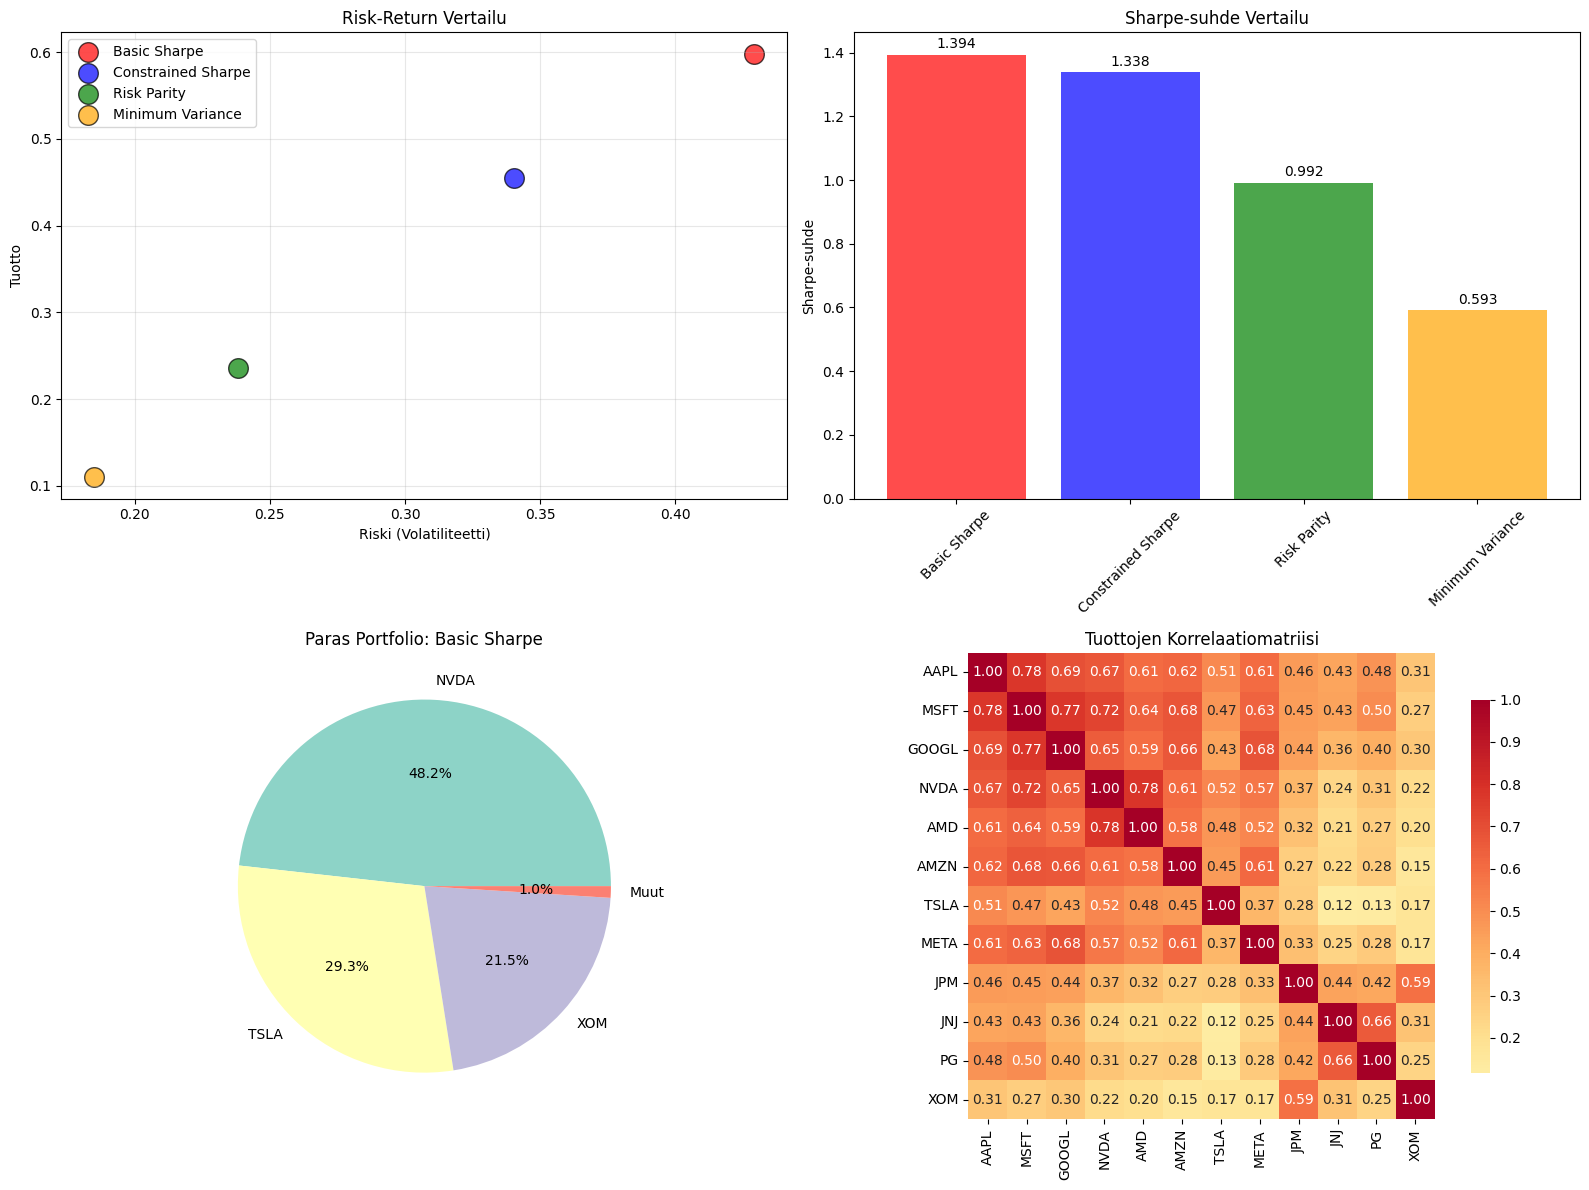


✅ Analyysi valmis!

KESKEISET HAVAINNOT:
• Rajoitettu optimointi estää ylikonsentraation
• Risk Parity jakaa riskit tasaisemmin
• Minimum Variance minimoi volatiliteetin
• Eri menetelmät sopivat eri riskiprofiileihin


In [4]:
class AdvancedPortfolioOptimizer:
    def __init__(self, stocks_dict, sectors_dict, start_date='2020-01-01', end_date='2024-01-01'):
        self.stocks = stocks_dict
        self.sectors = sectors_dict
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.returns = None
        
        # Optimoidut portfoliot eri menetelmillä
        self.portfolios = {}
        
    def fetch_data(self):
        """Hae osakekurssit"""
        print("🔄 Haetaan laaja osakedata...")
        data = {}
        successful_stocks = {}
        
        for name, ticker in self.stocks.items():
            try:
                stock_data = yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)
                
                # Käsittellään MultiIndex sarakkeet
                price_series = None
                if hasattr(stock_data.columns, 'levels'):
                    for col in stock_data.columns:
                        if col[0] in ['Adj Close', 'Close']:
                            price_series = stock_data[col]
                            break
                else:
                    if 'Adj Close' in stock_data.columns:
                        price_series = stock_data['Adj Close']
                    elif 'Close' in stock_data.columns:
                        price_series = stock_data['Close']
                
                if price_series is not None and len(price_series) > 100:
                    data[name] = price_series
                    successful_stocks[name] = ticker
                    print(f"✓ {name}")
                    
            except Exception as e:
                print(f"✗ {name}: {e}")
        
        # Päivitetään onnistuneet osakkeet
        self.stocks = successful_stocks
        self.data = pd.DataFrame(data).dropna()
        self.returns = self.data.pct_change().dropna()
        
        print(f"\n📊 Data haettu: {len(self.data)} päivää, {len(self.data.columns)} osaketta")
        return self.data
    
    def portfolio_metrics(self, weights):
        """Lasketaan portfolion perustiedot"""
        portfolio_return = np.sum(weights * self.returns.mean()) * 252
        portfolio_variance = np.dot(weights.T, np.dot(self.returns.cov() * 252, weights))
        portfolio_std = np.sqrt(portfolio_variance)
        sharpe_ratio = portfolio_return / portfolio_std if portfolio_std > 0 else 0
        return portfolio_return, portfolio_std, sharpe_ratio
    
    def optimize_basic(self):
        """Perus Sharpe-optimointi (vertailupohja)"""
        print("\n📈 Optimoidaan perus Sharpe-portfolio...")
        
        num_assets = len(self.stocks)
        
        def objective(weights):
            _, _, sharpe = self.portfolio_metrics(weights)
            return -sharpe
        
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(num_assets))
        initial_weights = np.array([1/num_assets] * num_assets)
        
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        
        if result.success:
            self.portfolios['Basic Sharpe'] = result.x
            return result.x
        return None
    
    def optimize_constrained(self, max_individual=0.25, max_sector=0.4, min_weight=0.02):
        """Rajoitettu optimointi - estää ylikonsentraation"""
        print(f"\n🛡️ Optimoidaan rajoitettu portfolio (max {max_individual:.0%} per osake, {max_sector:.0%} per sektori)...")
        
        num_assets = len(self.stocks)
        stock_names = list(self.stocks.keys())
        
        def objective(weights):
            _, _, sharpe = self.portfolio_metrics(weights)
            return -sharpe
        
        # Perusrajoitteet
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Summa = 100%
        ]
        
        # Sektorirajoitteet
        for sector, stocks_in_sector in self.sectors.items():
            sector_indices = [i for i, stock in enumerate(stock_names) if stock in stocks_in_sector]
            if sector_indices:
                constraints.append({
                    'type': 'ineq', 
                    'fun': lambda x, indices=sector_indices: max_sector - sum(x[i] for i in indices)
                })
        
        # Yksittäisten osakkeiden rajat
        bounds = tuple((min_weight, max_individual) for _ in range(num_assets))
        
        # Älykkäämpi aloitusarvaus - tasainen jakauma rajojen sisällä
        initial_weights = np.array([max_individual/2] * num_assets)
        initial_weights = initial_weights / np.sum(initial_weights)  # Normalisoi
        
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        
        if result.success:
            self.portfolios['Constrained Sharpe'] = result.x
            return result.x
        return None
    
    def optimize_risk_parity(self):
        """Risk Parity - tasaa riskikontribuutiot"""
        print("\n⚖️ Optimoidaan Risk Parity -portfolio...")
        
        def risk_budget_objective(weights):
            """Minimoi riskikontribuutioiden varianssia"""
            weights = np.array(weights)
            cov_matrix = self.returns.cov().values * 252
            
            # Portfolion kokonaisvarianssi
            portfolio_var = np.dot(weights.T, np.dot(cov_matrix, weights))
            
            # Marginaaliset riskikontribuutiot
            marginal_contrib = np.dot(cov_matrix, weights)
            
            # Riskikontribuutiot
            risk_contrib = weights * marginal_contrib / portfolio_var
            
            # Tavoite: kaikki riskikontribuutiot = 1/n
            target_contrib = np.ones(len(weights)) / len(weights)
            
            # Minimoidaan ero tavoitteesta
            return np.sum((risk_contrib - target_contrib) ** 2)
        
        num_assets = len(self.stocks)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0.01, 0.5) for _ in range(num_assets))
        initial_weights = np.array([1/num_assets] * num_assets)
        
        result = minimize(risk_budget_objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        
        if result.success:
            self.portfolios['Risk Parity'] = result.x
            return result.x
        return None
    
    def optimize_minimum_variance(self):
        """Minimum Variance - minimoi riskin"""
        print("\n🛡️ Optimoidaan Minimum Variance -portfolio...")
        
        def variance_objective(weights):
            """Minimoi portfolion varianssin"""
            _, portfolio_std, _ = self.portfolio_metrics(weights)
            return portfolio_std ** 2
        
        num_assets = len(self.stocks)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 0.4) for _ in range(num_assets))  # Max 40% per osake
        initial_weights = np.array([1/num_assets] * num_assets)
        
        result = minimize(variance_objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        
        if result.success:
            self.portfolios['Minimum Variance'] = result.x
            return result.x
        return None
    
    def calculate_advanced_risk_metrics(self, weights, portfolio_name="Portfolio"):
        """Lasketaan edistyneet riskimittarit"""
        portfolio_returns = (self.returns * weights).sum(axis=1)
        
        # Perus riskimittarit
        annual_return, annual_vol, sharpe = self.portfolio_metrics(weights)
        
        # Value at Risk (useita luottamustasoja)
        var_99 = np.percentile(portfolio_returns, 1)
        var_95 = np.percentile(portfolio_returns, 5)
        var_90 = np.percentile(portfolio_returns, 10)
        
        # Expected Shortfall (Conditional VaR)
        es_99 = portfolio_returns[portfolio_returns <= var_99].mean()
        es_95 = portfolio_returns[portfolio_returns <= var_95].mean()
        
        # Maximum Drawdown
        cumulative_returns = (1 + portfolio_returns).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        # Calmar Ratio (Annual Return / Max Drawdown)
        calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0
        
        # Sortino Ratio (downside risk)
        downside_returns = portfolio_returns[portfolio_returns < 0]
        downside_std = downside_returns.std() * np.sqrt(252)
        sortino_ratio = annual_return / downside_std if downside_std > 0 else 0
        
        return {
            'Portfolio': portfolio_name,
            'Annual_Return': annual_return,
            'Annual_Volatility': annual_vol,
            'Sharpe_Ratio': sharpe,
            'Sortino_Ratio': sortino_ratio,
            'Calmar_Ratio': calmar_ratio,
            'VaR_99': var_99,
            'VaR_95': var_95,
            'VaR_90': var_90,
            'ES_99': es_99,
            'ES_95': es_95,
            'Max_Drawdown': max_drawdown
        }
    
    def analyze_sector_allocation(self, weights):
        """Analysoi sektorijako"""
        stock_names = list(self.stocks.keys())
        sector_weights = {}
        
        for sector, stocks_in_sector in self.sectors.items():
            sector_weight = sum(weights[i] for i, stock in enumerate(stock_names) 
                               if stock in stocks_in_sector)
            if sector_weight > 0.01:  # Näytä vain merkittävät sektorit
                sector_weights[sector] = sector_weight
                
        return sector_weights
    
    def create_comparison_report(self):
        """Luodaan vertailuraportti eri optimointimenetelmistä"""
        print("\n" + "="*80)
        print("🔍 PORTFOLIO-OPTIMOINTIMENETELMIEN VERTAILU")
        print("="*80)
        
        if not self.portfolios:
            print("❌ Ei optimoituja portfolioita vertailtavaksi!")
            return
        
        # Lasketaan mittarit kaikille portfolioille
        comparison_data = []
        
        for name, weights in self.portfolios.items():
            metrics = self.calculate_advanced_risk_metrics(weights, name)
            comparison_data.append(metrics)
        
        # Luodaan DataFrame vertailua varten
        df_comparison = pd.DataFrame(comparison_data)
        
        print("\n📊 SUORITUSKYKYMITTARIT:")
        print("-" * 80)
        
        # Luodaan ja tulostetaan taulukko
        for _, row in df_comparison.iterrows():
            print(f"\n🎯 {row['Portfolio'].upper()}:")
            print(f"   Vuosituotto:     {row['Annual_Return']:8.2%}")
            print(f"   Volatiliteetti:  {row['Annual_Volatility']:8.2%}")
            print(f"   Sharpe-suhde:    {row['Sharpe_Ratio']:8.3f}")
            print(f"   Sortino-suhde:   {row['Sortino_Ratio']:8.3f}")
            print(f"   Calmar-suhde:    {row['Calmar_Ratio']:8.3f}")
            print(f"   VaR (95%):       {row['VaR_95']:8.2%}")
            print(f"   Max Drawdown:    {row['Max_Drawdown']:8.2%}")
        
        # Sektorijako analyysi
        print("\n" + "="*80)
        print("🏭 SEKTORIJAOT:")
        print("="*80)
        
        for name, weights in self.portfolios.items():
            sector_allocation = self.analyze_sector_allocation(weights)
            print(f"\n📈 {name.upper()}:")
            for sector, weight in sorted(sector_allocation.items(), 
                                       key=lambda x: x[1], reverse=True):
                print(f"   {sector:15}: {weight:6.1%}")
        
        return df_comparison
    
    def plot_comparison(self):
        """Visualisoidaan portfolioiden vertailu"""
        if not self.portfolios:
            print("❌ Ei portfolioita visualisoitavaksi!")
            return
            
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Risk-Return sirotin
        returns_list = []
        risks_list = []
        names_list = []
        
        for name, weights in self.portfolios.items():
            ret, risk, sharpe = self.portfolio_metrics(weights)
            returns_list.append(ret)
            risks_list.append(risk)
            names_list.append(name)
        
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for i, (ret, risk, name) in enumerate(zip(returns_list, risks_list, names_list)):
            ax1.scatter(risk, ret, s=200, c=colors[i % len(colors)], 
                       label=name, alpha=0.7, edgecolors='black')
        
        ax1.set_xlabel('Riski (Volatiliteetti)')
        ax1.set_ylabel('Tuotto')
        ax1.set_title('Risk-Return Vertailu')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Sharpe-suhde vertailu
        sharpe_ratios = [self.portfolio_metrics(weights)[2] for weights in self.portfolios.values()]
        bars = ax2.bar(names_list, sharpe_ratios, color=colors[:len(names_list)], alpha=0.7)
        ax2.set_title('Sharpe-suhde Vertailu')
        ax2.set_ylabel('Sharpe-suhde')
        ax2.tick_params(axis='x', rotation=45)
        
        # Lisätään arvot pylväiden päälle
        for bar, ratio in zip(bars, sharpe_ratios):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{ratio:.3f}', ha='center', va='bottom')
        
        # 3. Painojakauma - otetaan paras portfolio (korkein Sharpe)
        best_portfolio = max(self.portfolios.items(), 
                           key=lambda x: self.portfolio_metrics(x[1])[2])
        best_name, best_weights = best_portfolio
        
        stock_names = list(self.stocks.keys())
        colors_pie = plt.cm.Set3(np.linspace(0, 1, len(stock_names)))
        
        # Näytetään vain merkittävät painot (>2%)
        significant_weights = []
        significant_names = []
        other_weight = 0
        
        for i, (name, weight) in enumerate(zip(stock_names, best_weights)):
            if weight > 0.02:
                significant_weights.append(weight)
                significant_names.append(name)
            else:
                other_weight += weight
        
        if other_weight > 0:
            significant_weights.append(other_weight)
            significant_names.append('Muut')
        
        ax3.pie(significant_weights, labels=significant_names, autopct='%1.1f%%',
               colors=colors_pie[:len(significant_weights)])
        ax3.set_title(f'Paras Portfolio: {best_name}')
        
        # 4. Korrelaatiomatriisi (osaketuotot)
        corr_matrix = self.returns.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0,
                   square=True, ax=ax4, fmt='.2f', cbar_kws={'shrink': 0.8})
        ax4.set_title('Tuottojen Korrelaatiomatriisi')
        
        plt.tight_layout()
        plt.show()

def main():
    print("🚀 Kehittynyt portfolio-analyysi käynnistyy...\n")
    
    try:
        # Luodaan optimoija
        optimizer = AdvancedPortfolioOptimizer(STOCKS, SECTORS)
        
        # Haetaan data
        optimizer.fetch_data()
        
        if len(optimizer.data.columns) < 5:
            print("❌ Tarvitaan vähintään 5 osaketta edistyneeseen analyysiin")
            return
        
        # Optimoidaan eri menetelmillä
        print("\n🔄 Suoritetaan useita optimointimenetelmiä...")
        
        optimizer.optimize_basic()
        optimizer.optimize_constrained()
        optimizer.optimize_risk_parity()
        optimizer.optimize_minimum_variance()
        
        # Analysoidaan tulokset
        comparison_df = optimizer.create_comparison_report()
        
        # Visualisoidaan
        print("\n📊 Luodaan vertailukaaviot...")
        optimizer.plot_comparison()
        
        print("\n✅ Analyysi valmis!")
        print("\nKESKEISET HAVAINNOT:")
        print("• Rajoitettu optimointi estää ylikonsentraation")
        print("• Risk Parity jakaa riskit tasaisemmin")
        print("• Minimum Variance minimoi volatiliteetin")
        print("• Eri menetelmät sopivat eri riskiprofiileihin")
        
    except Exception as e:
        print(f"❌ Virhe: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()